K-Means

In [657]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [756]:
sql = '''
SELECT *  FROM `eth-tokens.test.clean_avg_with_balances_tokens`
'''

df = client.query(sql).to_dataframe()

In [757]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [758]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [759]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

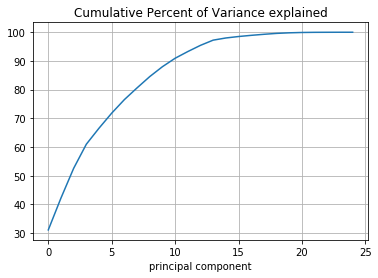

In [760]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

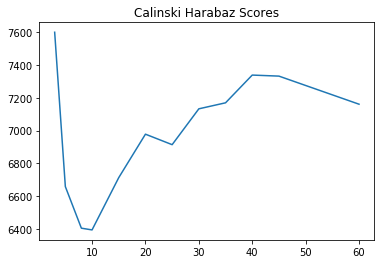

In [761]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [3,5,8,10,15,20,25,30,35,40,45,60]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

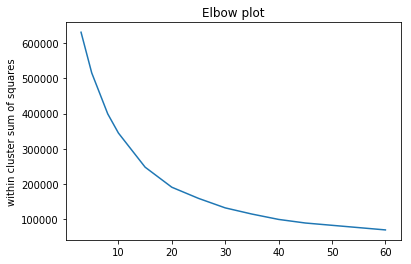

In [762]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [763]:
#optimal number of clusters is around 20
cl = KMeans(20)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [764]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [765]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

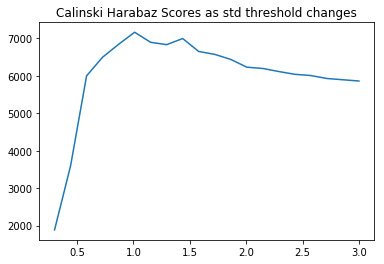

In [766]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [767]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,1)

In [768]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

<Figure size 432x288 with 0 Axes>

In [769]:
import time
from sklearn.manifold import TSNE
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.049s...
[t-SNE] Computed neighbors for 35917 samples in 10.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

Text(0,0.5,'second principcal component')

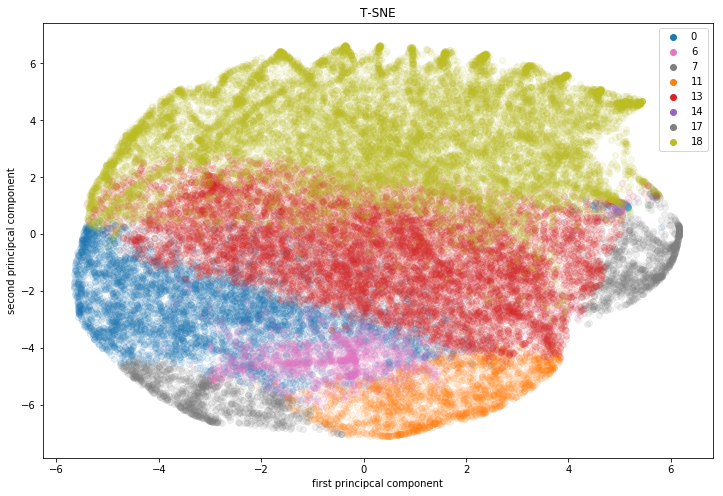

In [770]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <50:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principcal component')
plt.ylabel('second principcal component')

In [771]:
#3d
# time_start = time.time()
# tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(results)

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [772]:

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for c in np.unique(cl.labels_):
#     mask = cl.labels_==c
#     if np.sum(mask) <50:
#         lbl = '_nolegend_'
#     else:
#         lbl = c
#     ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], s=10, alpha=.01,label=lbl)
# leg = plt.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
# ax.set_xlabel('first principal component')
# ax.set_ylabel('second principal component')
# ax.set_zlabel('third principal component')
# ax.view_init(elev=30, azim=0)
# plt.show()


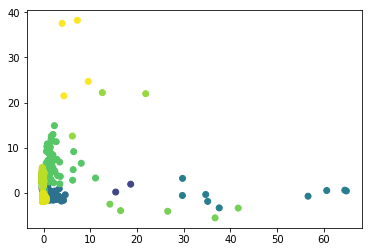

In [775]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

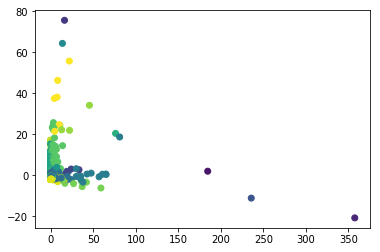

In [776]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [777]:
#recluster after changes
cl = KMeans(20).fit(results)
newcl = KMeans(20).fit(newresults)

In [778]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [779]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

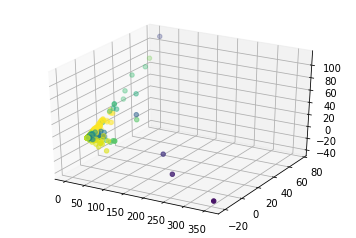

In [780]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

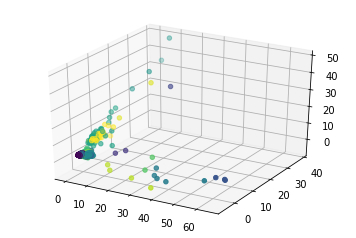

In [781]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [782]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [783]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [784]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
17,2.166356e+02,2.513759e+02,3.257403e+03,69.967765,1.462633e+06,3.308234e+04,3.594917e+03,89.516410,1.680318e+06,4.805992e+04,...,1.854867e+05,8.578111e-01,3.073027e+01,7.917122e+05,1.163638e+06,1.082665e+06,1.419875e+06,9.253560,422.977766,14536
11,3.083921e+02,2.731810e+02,3.835096e+03,73.146045,1.184451e+06,2.564740e+04,4.131567e+03,109.357473,1.130368e+06,2.369496e+04,...,6.111235e+04,3.289716e-01,8.682816e+00,1.125664e+06,1.959662e+06,1.386084e+06,2.220851e+06,21.871634,577.090758,9249
16,6.404636e+00,5.771570e+01,4.731779e+02,65.421810,1.824497e+05,2.800819e+04,9.468633e+02,83.908787,2.537643e+05,2.235886e+04,...,1.746798e+04,2.507903e-02,6.497366e-01,1.488809e+06,2.391021e+06,5.182232e+06,6.898356e+06,14.980400,483.356341,4745
0,1.162215e+01,7.596808e+00,9.404561e+02,72.505960,3.331664e+05,2.719785e+04,1.176288e+03,151.022429,2.676795e+05,4.292758e+04,...,1.805460e+04,9.903778e-02,2.378080e+00,4.959030e+06,7.459533e+06,2.536372e+06,3.625485e+06,15.656184,406.227245,4260
5,4.307820e+00,3.737937e+01,5.666648e+02,113.432179,1.451333e+05,3.028818e+04,1.269435e+03,149.437642,1.691764e+05,1.960319e+04,...,8.778672e+03,2.204659e-01,6.705491e-01,2.985100e+06,4.941913e+06,1.175641e+07,1.529269e+07,15.347754,758.233250,1202
9,1.256037e+04,2.993067e+03,6.126113e+04,84.834989,2.312617e+07,4.059773e+04,4.395669e+04,111.758293,1.886217e+07,4.162999e+04,...,1.171072e+06,1.161808e+02,1.517283e+03,7.110540e+05,1.289040e+06,6.401543e+05,1.120945e+06,78.580125,1548.585076,1117
7,1.192749e+01,4.401813e+00,1.336982e+03,99.203968,3.922621e+05,2.923372e+04,1.496349e+03,339.501891,1.665296e+05,4.246156e+04,...,8.324226e+03,1.782477e-01,6.412387e+00,1.303197e+07,1.787741e+07,5.114629e+06,7.231150e+06,15.897281,694.060081,662
19,2.867677e+01,7.649394e+02,3.127992e+05,7426.511965,6.336509e+07,2.467416e+06,1.550596e+05,11930.802339,4.448817e+07,2.324077e+06,...,3.631920e+06,1.066737e+03,1.451828e+03,3.343264e+06,4.655444e+06,2.622886e+06,4.179880e+06,36.010101,48176.957587,99
18,1.866454e+05,3.992539e+05,4.169325e+06,349.111222,8.454954e+08,1.228317e+05,4.333949e+06,1145.282957,8.969455e+08,1.652175e+05,...,7.014802e+07,7.894737e-01,9.805579e+03,8.044353e+03,5.482846e+04,5.208082e+04,7.780852e+04,169.315789,19552.226655,19
13,2.366667e+01,2.566667e+01,1.778397e+06,53058.259660,4.064904e+08,1.633519e+07,2.659710e+05,19042.174701,6.421962e+07,6.402286e+06,...,7.588298e+06,1.666667e-01,3.683333e+01,7.189501e+06,8.208176e+06,1.620932e+06,3.001604e+06,46.833333,185310.577596,6


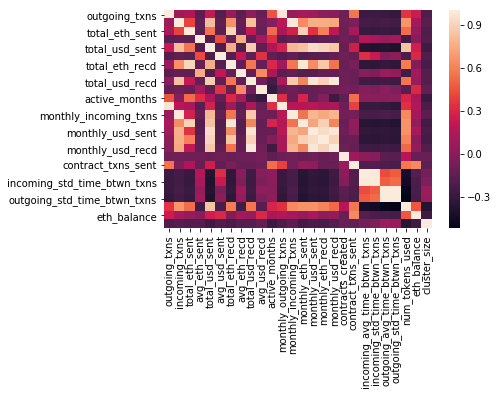

In [785]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [786]:
arr = df_summary.values

In [787]:
arr.shape

(20, 26)

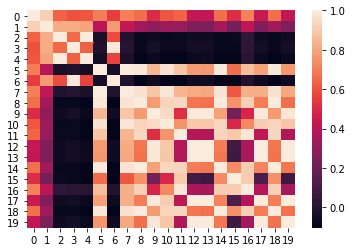

In [788]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

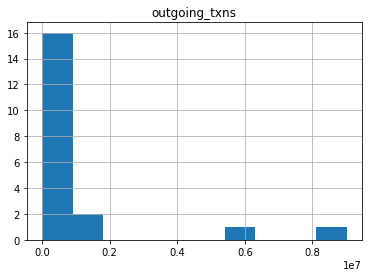

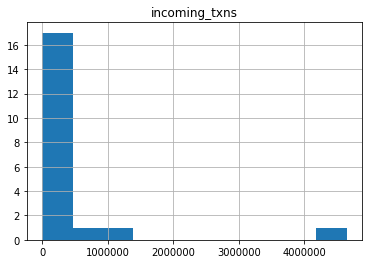

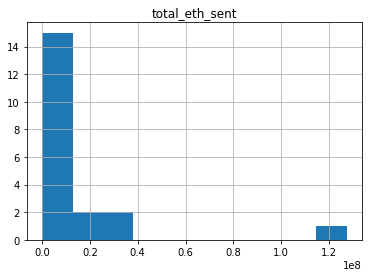

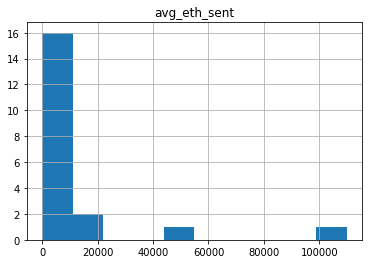

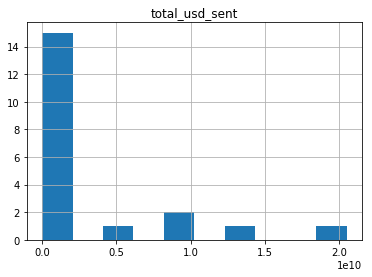

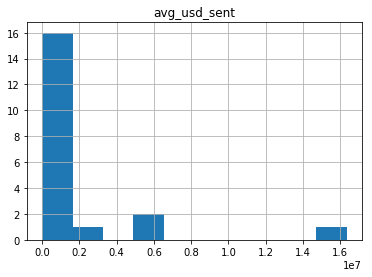

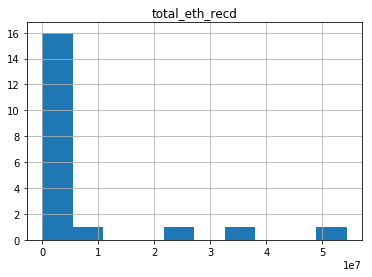

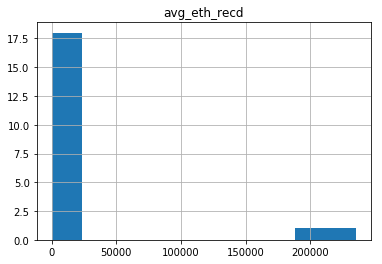

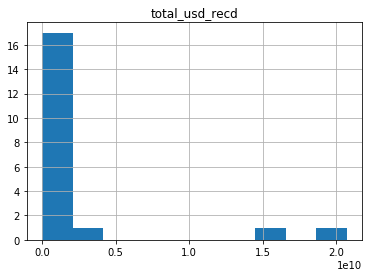

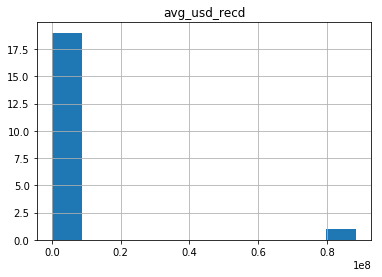

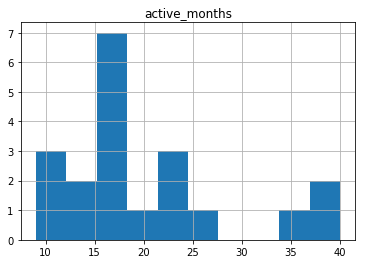

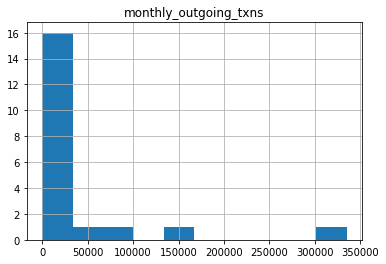

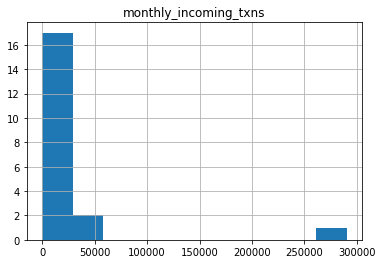

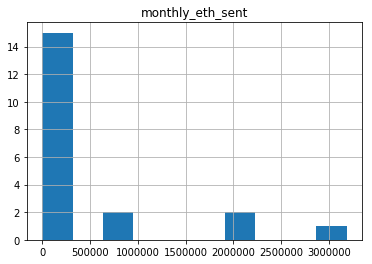

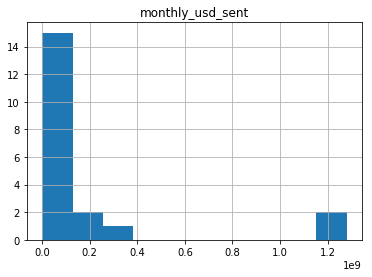

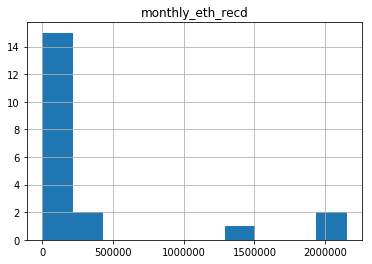

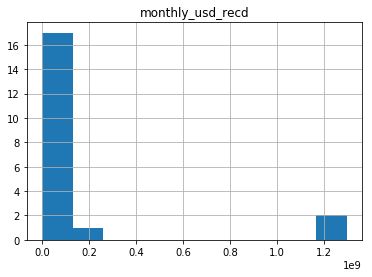

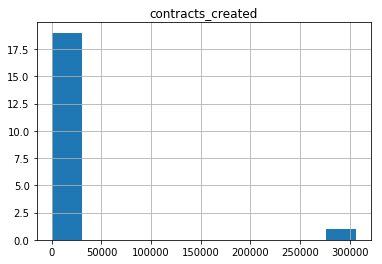

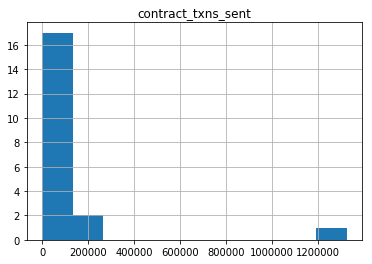

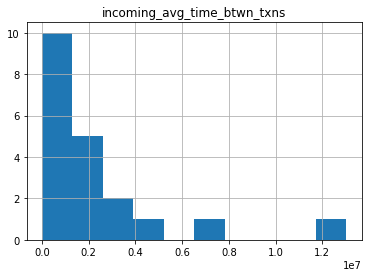

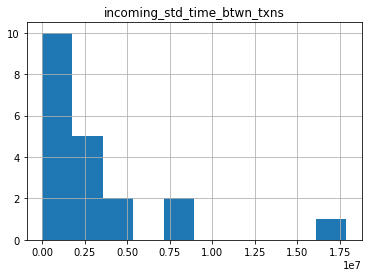

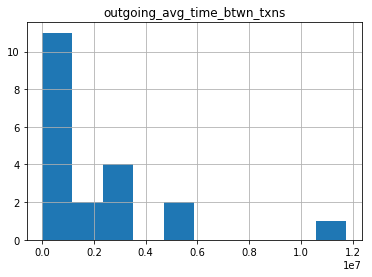

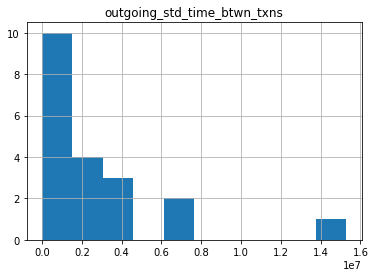

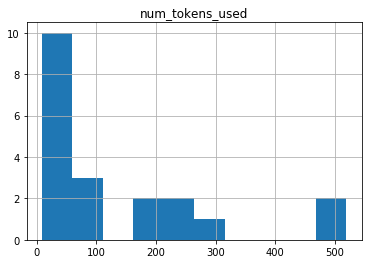

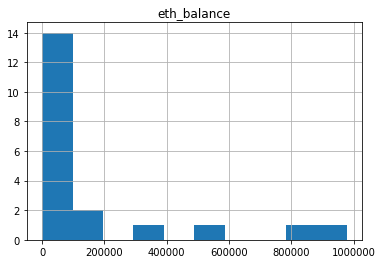

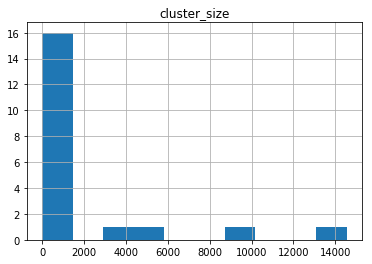

In [789]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [790]:
p = PCA(n_components=3)

In [791]:
vectors = p.fit_transform(arr[:8,:])

In [792]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

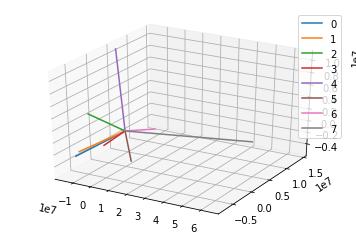

In [793]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()

In [794]:
sql = '''
SELECT es.label, a.*  FROM `eth-tokens.test.clean_avg_with_balances_tokens` a
INNER JOIN `eth-tokens.alldata.etherscan` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''

dflabel = client.query(sql).to_dataframe()

In [795]:
dflabel

,label,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,...,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance
0,Bgogo_2,0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f,36,5043,57900,1608.333333333,1.248853e+07,3.469036e+05,61671.7841197,12.229185826,...,20557.261373233,4.418291e+06,0,0,9.234072e+02,1.880744e+04,1.373183e+05,1.435795e+05,16,4361.036312862
1,Rate3_Wallet2,0x841991ffe0dafd619bc517d82ee4700c37136140,7,5,5040,720,1.877741e+06,2.682487e+05,9684.7308,1936.94616,...,1936.94616,8.097912e+05,0,0,1.017963e+06,1.390813e+06,7.171660e+05,1.001970e+06,3,4644.727651874
2,Bitmax_1,0x03bdf69b1322d623836afbd27679a1c0afa067e9,1061,1081,3348.282084541,3.155779533,7.798949e+05,7.350565e+02,6077.344511858,5.621965321,...,1215.468902372,2.748006e+05,0,0,9.625878e+03,6.593208e+04,9.759738e+03,5.313994e+04,13,3871.119196898
3,Bitmax_2,0x4b1a99467a284cc690e3237bc69105956816f762,3,1303,260,86.666666667,5.097040e+04,1.699013e+04,2958.985716476,2.270902315,...,591.797143295,1.608649e+05,0,0,8.146992e+03,1.386719e+05,1.307516e+06,1.848834e+06,3,2698.982399248
4,BigONE_1,0xd4dcd2459bb78d7a645aa7e196857d421b10d93f,18665,13530,146649.064314301,7.856901383,5.504761e+07,2.949242e+03,157472.714797711,11.638781582,...,26245.452466285,9.651075e+06,0,0,9.686476e+02,2.607501e+03,7.018620e+02,1.844994e+03,161,10262.461085817
5,Coinrail_Hack,0xf6884686a999f5ae6c1af03db92bab9c6d7dc8de,5,4,1693.512132673,338.702426535,3.760820e+05,7.521639e+04,8947,2236.75,...,1491.166666667,5.627703e+05,0,0,2.722357e+06,2.854648e+06,2.040091e+06,3.271049e+06,3,7446.134010779
6,Fake_Phishing1431,0xdf9191889649c442836ef55de5036a7b694115b6,9,7,13747,1527.444444444,4.363486e+06,4.848317e+05,15526.883550987,2218.12622157,...,2587.813925165,6.351271e+05,0,0,1.372057e+06,2.722141e+06,1.035478e+06,1.945720e+06,15,11371.001874184
7,FCoin,0x915d7915f2b469bb654a7d903a5d4417cb8ea7df,109642,96188,1394892.185457732,12.722243168,6.119790e+08,5.581611e+03,1405578.772196829,14.612828754,...,200796.96745669,8.833216e+07,0,0,1.524179e+02,1.718613e+03,1.337268e+02,9.264247e+02,277,8559.252901756
8,Gate.io_3,0x1c4b70a3968436b9a0a9cf5205c787eb81bb558c,30,23950,233001,7766.7,1.041474e+08,3.471581e+06,334390.504971634,13.96202526,...,47770.072138805,2.332060e+07,0,0,6.722500e+02,2.086491e+04,5.404926e+05,7.061366e+05,194,101389.290293502
9,Perlin_TokenSale,0x746aaac06b04c36f5fea9bbb35ca75518eda1cca,26,167,19212.15969,738.929218846,5.190490e+06,1.996342e+05,45299.11369,271.252177784,...,6471.301955714,3.234727e+06,0,0,3.721066e+04,1.323550e+05,4.390101e+05,1.097196e+06,8,28370.769605


In [796]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [797]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [798]:
dflabel

,label,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster
0,Bgogo_2,0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f,36,5043,57900,1608.333333333,1.248853e+07,3.469036e+05,61671.7841197,12.229185826,...,4.418291e+06,0,0,9.234072e+02,1.880744e+04,1.373183e+05,1.435795e+05,16,4361.036312862,17
1,Rate3_Wallet2,0x841991ffe0dafd619bc517d82ee4700c37136140,7,5,5040,720,1.877741e+06,2.682487e+05,9684.7308,1936.94616,...,8.097912e+05,0,0,1.017963e+06,1.390813e+06,7.171660e+05,1.001970e+06,3,4644.727651874,17
2,Bitmax_1,0x03bdf69b1322d623836afbd27679a1c0afa067e9,1061,1081,3348.282084541,3.155779533,7.798949e+05,7.350565e+02,6077.344511858,5.621965321,...,2.748006e+05,0,0,9.625878e+03,6.593208e+04,9.759738e+03,5.313994e+04,13,3871.119196898,17
3,Bitmax_2,0x4b1a99467a284cc690e3237bc69105956816f762,3,1303,260,86.666666667,5.097040e+04,1.699013e+04,2958.985716476,2.270902315,...,1.608649e+05,0,0,8.146992e+03,1.386719e+05,1.307516e+06,1.848834e+06,3,2698.982399248,17
4,BigONE_1,0xd4dcd2459bb78d7a645aa7e196857d421b10d93f,18665,13530,146649.064314301,7.856901383,5.504761e+07,2.949242e+03,157472.714797711,11.638781582,...,9.651075e+06,0,0,9.686476e+02,2.607501e+03,7.018620e+02,1.844994e+03,161,10262.461085817,9
5,Coinrail_Hack,0xf6884686a999f5ae6c1af03db92bab9c6d7dc8de,5,4,1693.512132673,338.702426535,3.760820e+05,7.521639e+04,8947,2236.75,...,5.627703e+05,0,0,2.722357e+06,2.854648e+06,2.040091e+06,3.271049e+06,3,7446.134010779,17
6,Fake_Phishing1431,0xdf9191889649c442836ef55de5036a7b694115b6,9,7,13747,1527.444444444,4.363486e+06,4.848317e+05,15526.883550987,2218.12622157,...,6.351271e+05,0,0,1.372057e+06,2.722141e+06,1.035478e+06,1.945720e+06,15,11371.001874184,17
7,FCoin,0x915d7915f2b469bb654a7d903a5d4417cb8ea7df,109642,96188,1394892.185457732,12.722243168,6.119790e+08,5.581611e+03,1405578.772196829,14.612828754,...,8.833216e+07,0,0,1.524179e+02,1.718613e+03,1.337268e+02,9.264247e+02,277,8559.252901756,18
8,Gate.io_3,0x1c4b70a3968436b9a0a9cf5205c787eb81bb558c,30,23950,233001,7766.7,1.041474e+08,3.471581e+06,334390.504971634,13.96202526,...,2.332060e+07,0,0,6.722500e+02,2.086491e+04,5.404926e+05,7.061366e+05,194,101389.290293502,19
9,Perlin_TokenSale,0x746aaac06b04c36f5fea9bbb35ca75518eda1cca,26,167,19212.15969,738.929218846,5.190490e+06,1.996342e+05,45299.11369,271.252177784,...,3.234727e+06,0,0,3.721066e+04,1.323550e+05,4.390101e+05,1.097196e+06,8,28370.769605,17


In [734]:
b = df_summary['cluster_size'] [df_summary['cluster_size']<50]

In [743]:

df[cl.labels_==24]

,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,...,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance
6676,0x005bdf2845064db405f5c99aaf9510d0b19e7ac2,4,14,101,25.25,2.808010e+04,7020.024750,38677.9,2762.707142857,1.073552e+07,...,7735.58,2.147103e+06,0,0,3.051737e+05,1.098686e+06,1.322008e+06,2.285680e+06,1,38576.89916
17504,0x0cbcf55a157a750f532082a5a5b8e154a429ac0f,6,9,252.344,42.057333333,6.520569e+04,10867.614933,31027.375,3447.486111111,8.017474e+06,...,2068.491666667,5.344982e+05,0,0,6.090000e+02,3.703604e+02,8.276000e+02,5.438357e+02,29,30775.0251095
24988,0x03e1fa19a43ef3d4b16889ed2ad0a72e098cb7ab,9,3,10930,1214.444444444,6.366725e+06,707413.888889,47634,15878,4.763400e+04,...,1287.405405405,1.287405e+03,0,0,3.479750e+04,4.856197e+04,2.343169e+06,2.944832e+06,48,36703.9964699
28933,0x04786aada9deea2150deab7b3b8911c309f5ed90,12,15,21601,1800.083333333,3.397216e+05,28310.131667,58858.52257155,3923.90150477,5.648607e+05,...,1898.662018437,1.822131e+04,0,0,4.621760e+06,1.510953e+07,2.561854e+06,7.338414e+06,29,37257.517492309
39632,0x00832a758a781055ac19b5f9bf553db8bb9db32d,48,4,37817.05711,787.855356458,2.118394e+07,441332.183314,6.66832736,1.66708184,2.019970e+03,...,0.41677046,1.262481e+02,0,0,3.611279e+06,3.442216e+06,5.574270e+05,7.901210e+05,47,57189.572080357


In [753]:
'0x7a10ec7d68a048bdae36a70e93532d31423170fa' in df['address'].values

False